In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

np.set_printoptions(threshold=np.inf)
%load_ext autoreload
%autoreload 2

# load python modules
SRC_PATH = '/Users/tabea/Documents/UrbanMobility/src'
import sys
sys.path.append(SRC_PATH)
from models_ml_dl import deep_learning_model as dl_models
from visualization import model_evaluation as eval

# Borough-Specific Multi-Series Deep Learning Models

### Data Preparation

In [ ]:
boroughs = ['Westminster', 'Tower Hamlets', 'Kensington and Chelsea', 'Camden', 'Hammersmith and Fulham', 'Lambeth', 'Wandsworth', 'Southwark', 
            'Hackney', 'City of London', 'Islington', 'Newham']

In [2]:
# load data

journey_hourly_16 = pd.read_csv('../data/processed/aggregated_journey_data/agg_journey_data_hourly_2016.csv', parse_dates=['start_date'], index_col=0)
journey_hourly_17 = pd.read_csv('../data/processed/aggregated_journey_data/agg_journey_data_hourly_2017.csv', parse_dates=['start_date'], index_col=0)
journey_hourly_18 = pd.read_csv('../data/processed/aggregated_journey_data/agg_journey_data_hourly_2018.csv', parse_dates=['start_date'], index_col=0)
journey_hourly_19 = pd.read_csv('../data/processed/aggregated_journey_data/agg_journey_data_hourly_2019.csv', parse_dates=['start_date'], index_col=0)

# use 2016, 2017 and 2018 as train data and 2019 as test data
journey_train_orig = pd.concat([journey_hourly_16, journey_hourly_17, journey_hourly_18])
journey_test_orig = journey_hourly_19.copy()

# remove start_data and demand column 
journey_train = journey_train_orig.drop(columns=['start_date', 'demand'])
journey_test = journey_test_orig.drop(columns=['start_date', 'demand'])

In [3]:
# min max scaling: the scaler is fit on the training data and then used to transform both the training and test data. The target variable demand is not scaled.

journey_train_scaled, journey_test_scaled = dl_models.min_max_scaling(journey_train, journey_test, journey_train_orig, journey_test_orig)

In [4]:
# arrange data to 3D tensor with shape [batch, timesteps, feature] and split to train and test.

lookback = 96
X_train, Y_train, X_test, Y_test = dl_models.create_train_test_data(journey_train_scaled, journey_test_scaled, lookback, boroughs)

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(313596, 96, 105) (313596,)
(103644, 96, 105) (103644,)


### LSTM Modelling

In [7]:
# model preparation

# hyperparameters
units=60
dropout=0.05
reg=0.0
patience = 6
learning_rate = 0.001
epochs = 30
batch_size = 32
validation_split= 0.2

# create model
lstm_model = dl_models.create_lstm(X_train, units=units, dropout=dropout, reg=reg)
lstm_model.summary()

# add adam optimizer
lstm_model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mae')

# create a modelcheckpoint callback to save all models after each epoch
checkpoint = ModelCheckpoint(
    "../models/lstm_model_epoch_{epoch}.h5",  
    monitor="val_loss",  
    verbose=1,  
    save_best_only=False, 
    mode="auto",  
    save_freq="epoch",
)

# create earlystoppping and add the checkpoint callback
callbacks = [EarlyStopping(monitor='val_loss', patience = patience), checkpoint]

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 96, 60)            39840     
                                                                 
 dropout_4 (Dropout)         (None, 96, 60)            0         
                                                                 
 lstm_5 (LSTM)               (None, 96, 60)            29040     
                                                                 
 dropout_5 (Dropout)         (None, 96, 60)            0         
                                                                 
 lstm_6 (LSTM)               (None, 96, 60)            29040     
                                                                 
 dropout_6 (Dropout)         (None, 96, 60)            0         
                                                                 
 lstm_7 (LSTM)               (None, 60)               

In [9]:
# fit and predict

lstm_history = lstm_model.fit(X_train, Y_train, epochs = epochs, batch_size = batch_size, 
                    validation_split= validation_split, callbacks = callbacks)

lstm_pred = lstm_model.predict(X_test)

Epoch 1/30
7840/7840 [==============================] - ETA: 0s - loss: 49.8297
Epoch 1: saving model to ../models/lstm_model_epoch_1.h5
7840/7840 [==============================] - 1054s 134ms/step - loss: 49.8297 - val_loss: 26.0126
Epoch 2/30
7840/7840 [==============================] - ETA: 0s - loss: 17.7356
Epoch 2: saving model to ../models/lstm_model_epoch_2.h5
7840/7840 [==============================] - 1060s 135ms/step - loss: 17.7356 - val_loss: 13.6840
Epoch 3/30
7840/7840 [==============================] - ETA: 0s - loss: 11.3359
Epoch 3: saving model to ../models/lstm_model_epoch_3.h5
7840/7840 [==============================] - 1094s 140ms/step - loss: 11.3359 - val_loss: 9.3510
Epoch 4/30
7840/7840 [==============================] - ETA: 0s - loss: 8.1107
Epoch 4: saving model to ../models/lstm_model_epoch_4.h5
7840/7840 [==============================] - 1034s 132ms/step - loss: 8.1107 - val_loss: 6.2861
Epoch 5/30
7840/7840 [==============================] - ETA: 0s 

In [11]:
# evaluation

mae = mean_absolute_error(Y_test, lstm_pred)
rmse = mean_squared_error(Y_test, lstm_pred, squared=False)
r_squared = r2_score(Y_test, lstm_pred)

print("MAE: ", mae )
print( "RMSE: ", rmse )
print("R2: ", r_squared)

MAE:  3.8291443084870864
RMSE:  21.090443025183504
R2:  0.9767491470944532


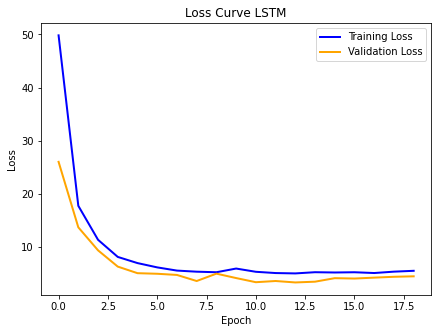

In [12]:
# loss curve

eval.loss_curve(lstm_history, 'Loss Curve LSTM')

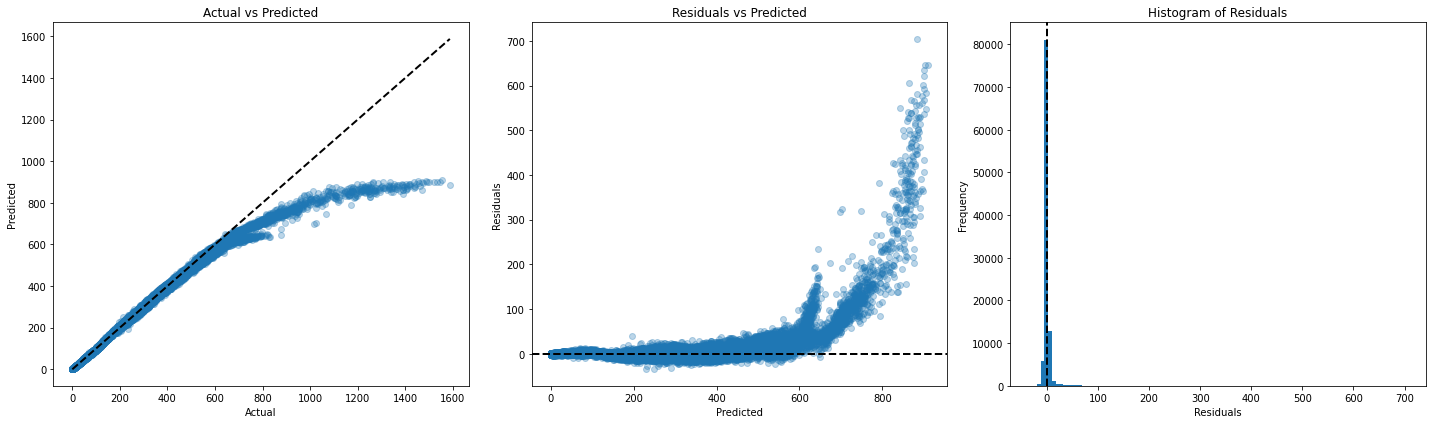

In [13]:
# evaluation plots 

eval.evaluation_vis(Y_test, lstm_pred.reshape(-1))

1152


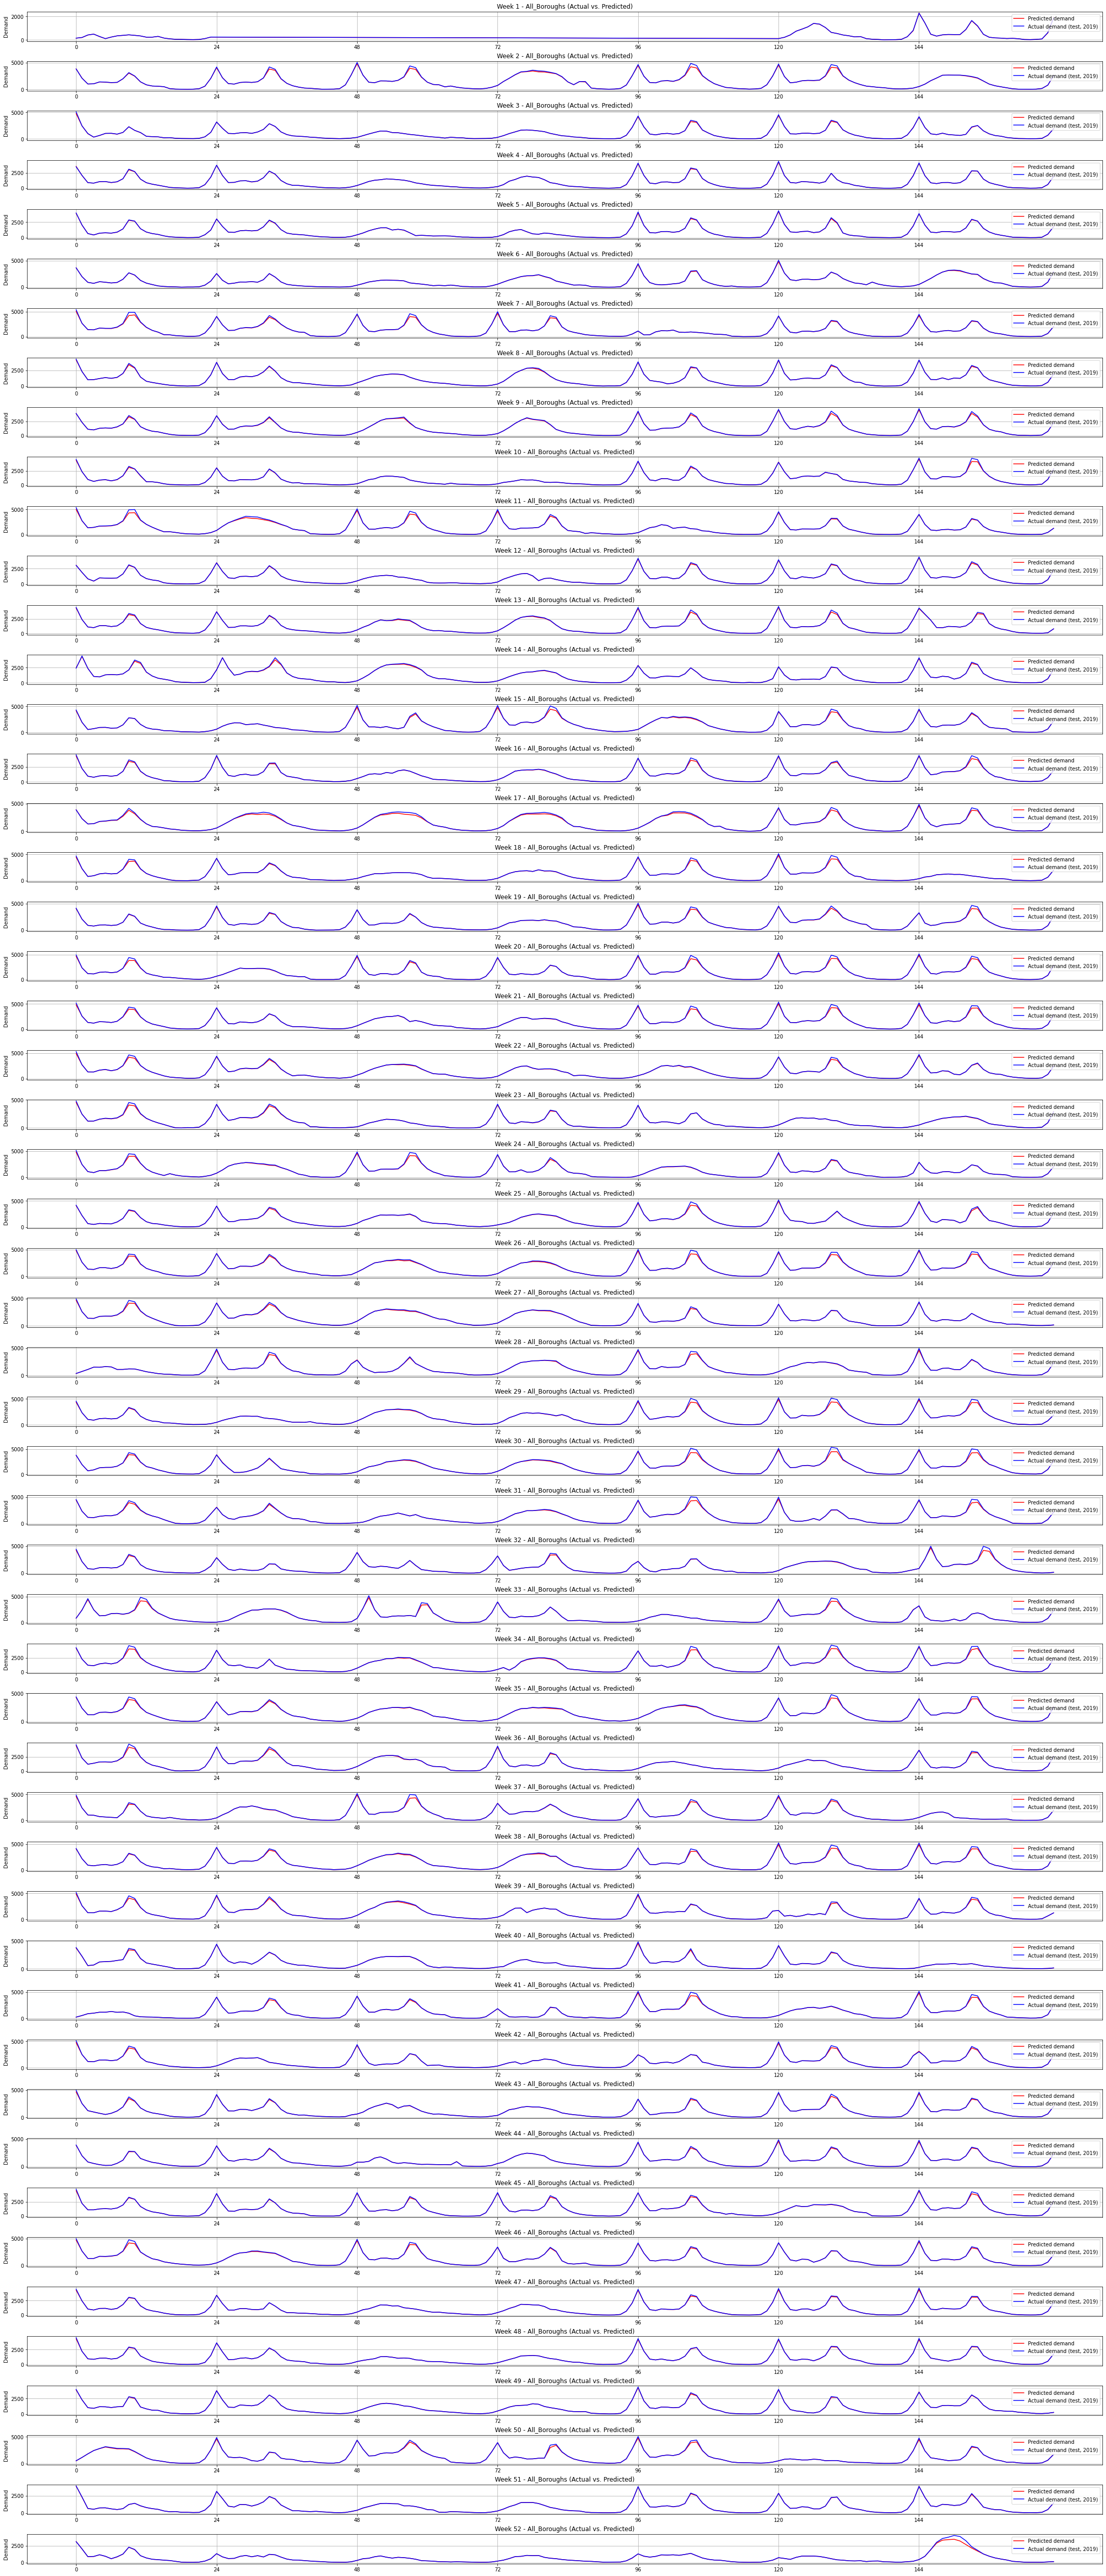

In [14]:
# visualisation: pred vs actual

num_rows_to_cut = journey_test_orig.shape[0] - Y_test.shape[0]
journey_test_orig = journey_test_orig.iloc[num_rows_to_cut:, :]

eval.evaluation_actual_vs_predicted_hourly(Y_test, lstm_pred, journey_test_orig, 'All_Boroughs', 'model_lstm')

In [ ]:
# visualisation: pred vs actual per borough

for borough in boroughs:
    eval.evaluation_actual_vs_predicted_hourly(Y_test, lstm_pred, journey_test_orig, borough, 'model_lstm')

### Transformer Modelling

In [5]:
# add positional encoding

X_train = dl_models.add_positional_encoding(X_train)
X_test = dl_models.add_positional_encoding(X_test)

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(313596, 96, 105) (313596,)
(103644, 96, 105) (103644,)


In [ ]:
# model preparation

# hyperparams
num_heads=4
dropout_rate=0.05
num_layers=2
batch_size=32
learning_rate=0.00001
validation_split=0.2
patience=12
epochs=35

# create model
tr_model = dl_models.Transformer(num_heads, dropout_rate, num_layers)

In [ ]:
# fit and predict

history_tr = tr_model.train(X_train, Y_train, batch_size, learning_rate, validation_split, patience, epochs)

tr_pred = tr_model.predict(X_test)

In [15]:
# evaluation

mae = mean_absolute_error(Y_test, tr_pred)
rmse = mean_squared_error(Y_test, tr_pred, squared=False)
r_squared = r2_score(Y_test, tr_pred)

print("MAE: ", mae )
print( "RMSE: ", rmse )
print("R2: ", r_squared)

MAE:  1.3788255082165084
RMSE:  3.275617484949412
R2:  0.9994391408044095


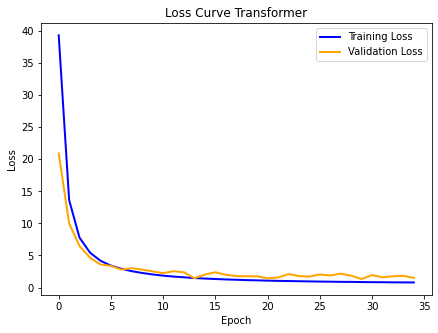

In [16]:
# loss curve

eval.loss_curve(history_tr, 'Loss Curve Transformer')

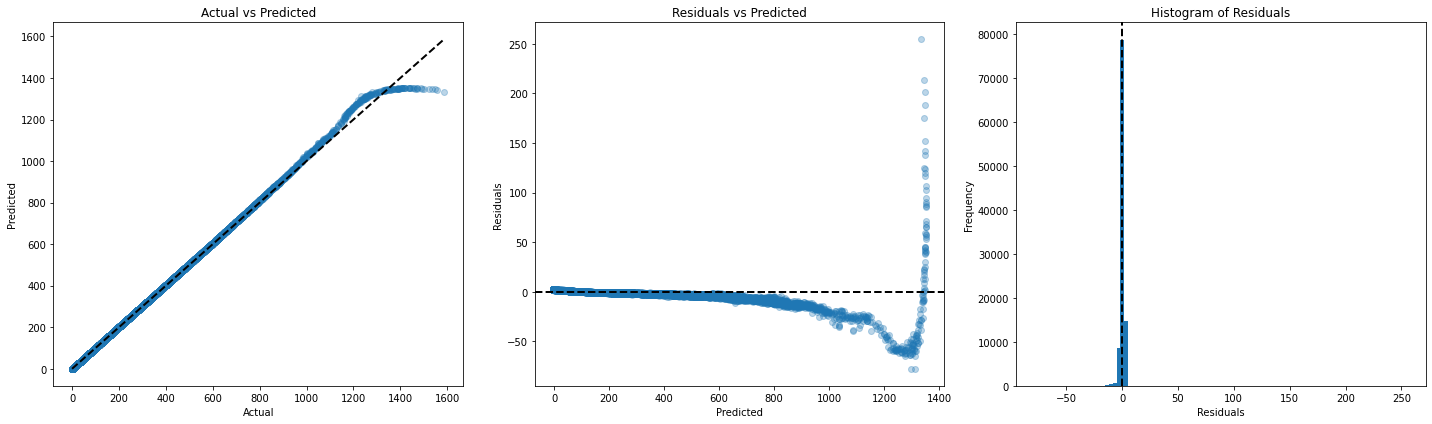

In [18]:
# evaluation visualisation

eval.evaluation_vis(Y_test, tr_pred.flatten())

In [ ]:
# visualisation: pred vs actual

num_rows_to_cut = journey_test_orig.shape[0] - Y_test.shape[0]
journey_test_orig = journey_test_orig.iloc[num_rows_to_cut:, :]

eval.evaluation_actual_vs_predicted_hourly(Y_test, tr_pred, journey_test_orig, 'All_Boroughs', 'model_transformer')

In [26]:
# visualisation: pred vs actual per borough

for borough in boroughs:
    eval.evaluation_actual_vs_predicted_hourly(Y_test, tr_pred, journey_test_orig, borough, 'model_transformer')